In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from tqdm.auto import tqdm
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
#     name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
# plt.rc('font', family='NanumBarunGothic')
fe = fm.FontEntry(
    fname=r'/System/Library/Fonts/Supplemental/AppleGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='AppleGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'})  # 폰트 설정
plt.rc('font', family='AppleGothic')

In [3]:
train = pd.read_csv('../03_outlier/train_processed.csv')
test = pd.read_csv('../03_outlier/test_processed.csv')

In [4]:
train.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식',
       'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사',
       'k_사용검사일-사용승인일', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60㎡이하_',
       'k_전용면적별세대현황_60㎡~85㎡이하_', 'k_85㎡~135㎡이하', 'k_수정일자', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', 'is_test', '주소', '경도', '위도', '1_bus', '3_bus',
       '5_bus', '10_bus', '1_school', '3_school', '5_school', '10_school',
       'bus_access_score', 'sub_access_score', 'school_access_score', '1_sub',
       '3_sub', '5_sub', '10_sub', '계약연도', '계약월', '구', '동', '아파트_최고층',
       '층_최고층대비비율', '층구간_상대', '구_해당달_거래수', '동_해당달_거래수', '구_직전달까지누적거래수',
       '동_직전달까지누적거래수', '동대구_해당달_비율', '동대구_직전누적_비율', '연식', '연식_bin', '강남여부',
       '브랜드', 'area_bin_in_region', 'target_log_clip'],
      dtype='object')

In [5]:
target_col = 'target_log_clip'

In [6]:
# 범주형 컬럼 자동 탐지 + 명시적 범주형 포함
auto_cats = train.select_dtypes(include=['object', 'category']).columns.tolist()
explicit_cats = ['연식_bin', '층구간_상대', '브랜드', '아파트명', '도로명', '주소', '구', '동', 'area_bin_in_region']
cat_cols = [c for c in (set(auto_cats) | set(explicit_cats)) if c in train.columns]

In [7]:
# Train/Test 합쳐 카테고리 정합
if len(cat_cols) > 0:
    concat = pd.concat([train[cat_cols], test[cat_cols]], axis=0, ignore_index=True)
    for c in cat_cols:
        concat[c] = concat[c].astype('category')
    for c in cat_cols:
        train[c] = pd.Categorical(train[c], categories=concat[c].cat.categories)
        test[c] = pd.Categorical(test[c], categories=concat[c].cat.categories)

In [8]:
# 피처/타깃 분리 (is_test는 정보량이 없으므로 제거)
drop_cols = [target_col]
if 'is_test' in train.columns:
    drop_cols.append('is_test')

In [9]:
X = train.drop(columns=drop_cols)
y = train[target_col].astype(float)
X_test = test.drop(columns=['is_test']) if 'is_test' in test.columns else test.copy()

In [10]:
categorical_feature = cat_cols
print(f"[INFO] 사용 범주형 컬럼: {categorical_feature}")
print(f"[INFO] X.shape={X.shape}, X_test.shape={X_test.shape}")

[INFO] 사용 범주형 컬럼: ['청소비관리형태', 'k_건설사_시공사_', '세대전기계약방법', 'area_bin_in_region', 'k_수정일자', '동', 'k_세대타입_분양형태_', '브랜드', '도로명', 'k_복도유형', '주소', '층구간_상대', 'k_사용검사일-사용승인일', 'k_단지분류_아파트_주상복합등등_', 'k_시행사', '경비비관리형태', 'k_팩스번호', '아파트명', 'k_관리방식', '연식_bin', 'k_난방방식', '구', 'k_전화번호']
[INFO] X.shape=(96698, 67), X_test.shape=(9272, 67)


In [11]:
# K-Fold 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)

# 베스트 폴드 단일 모델만 선택
best_model = None
best_fold = None
best_fold_rmse = np.inf
best_iteration = None

base_params = dict(
    random_state=2023,
    n_estimators=50000,
    learning_rate=0.02,
    objective="regression",
    metric="rmse",
    num_leaves=127,
    max_depth=10,
    min_data_in_leaf=50,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l2=3.0,
    lambda_l1=0.0,
    min_gain_to_split=0.0,
    max_bin=255,
    verbosity=-1
)

oof_pred_log = np.zeros(len(X))
fold_rmses = []

In [12]:
def lgbm_tqdm_callback(pbar):
    """
    LightGBM 콜백: 부스팅 반복마다 tqdm 진행바 업데이트
    """
    def _callback(env):
        # 첫 호출 시 총 반복 수를 정확히 설정 (early stopping 고려)
        if env.iteration == env.begin_iteration:
            total = env.end_iteration - env.begin_iteration
            try:
                pbar.reset(total=total)
            except Exception:
                pass
        pbar.update(1)
        # 마지막 반복에서 자동 close
        if env.iteration + 1 >= env.end_iteration:
            pbar.close()
    _callback.order = 200  # 기본 콜백 뒤쪽에서 실행
    return _callback

In [13]:
for fold, (trn_idx, val_idx) in enumerate(tqdm(kf.split(X, y), total=n_splits, desc="KFold"), start=1):
    print(f"[KFold] Fold {fold}/{n_splits} 학습 중...")
    X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    model = lgb.LGBMRegressor(**base_params)

    # 폴드별 부스팅 진행바
    pbar = tqdm(total=base_params["n_estimators"], desc=f"Fold {fold} boosting", leave=False)

    model.fit(
        X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_feature,
        callbacks=[
            lgb.early_stopping(stopping_rounds=300, verbose=False),
            lgb.log_evaluation(period=0),            # <- 평가 로그 숨기기
            lgbm_tqdm_callback(pbar),                # <- tqdm 진행 표시
        ]
    )

    val_pred_log = model.predict(X_val, num_iteration=model.best_iteration_)
    oof_pred_log[val_idx] = val_pred_log

    # 원스케일 RMSE
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val.values), np.expm1(val_pred_log)))
    fold_rmses.append(rmse)
    print(f"[KFold] Fold {fold} RMSE(orig) = {rmse:,.5f}, best_iter = {model.best_iteration_}")

    # 베스트 폴드 갱신
    if rmse < best_fold_rmse:
        best_fold_rmse = rmse
        best_fold = fold
        best_model = model
        best_iteration = model.best_iteration_


KFold:   0%|          | 0/5 [00:00<?, ?it/s]

[KFold] Fold 1/5 학습 중...


Fold 1 boosting:   0%|          | 0/50000 [00:00<?, ?it/s]

[KFold] Fold 1 RMSE(orig) = 5,524.67731, best_iter = 19038
[KFold] Fold 2/5 학습 중...


Fold 2 boosting:   0%|          | 0/50000 [00:00<?, ?it/s]

[KFold] Fold 2 RMSE(orig) = 4,865.30576, best_iter = 17249
[KFold] Fold 3/5 학습 중...


Fold 3 boosting:   0%|          | 0/50000 [00:00<?, ?it/s]

[KFold] Fold 3 RMSE(orig) = 5,434.58669, best_iter = 21126
[KFold] Fold 4/5 학습 중...


Fold 4 boosting:   0%|          | 0/50000 [00:00<?, ?it/s]

[KFold] Fold 4 RMSE(orig) = 5,658.57846, best_iter = 19820
[KFold] Fold 5/5 학습 중...


Fold 5 boosting:   0%|          | 0/50000 [00:00<?, ?it/s]

[KFold] Fold 5 RMSE(orig) = 5,040.74634, best_iter = 18119


In [14]:
# 학습데이터 예측 (로그스케일 -> 원스케일)
preds_train_log = best_model.predict(X)
y_true = np.expm1(y.values)
y_pred = np.expm1(preds_train_log)

[Train In-sample] RMSE(orig) = 2,774.6330
[Train In-sample] MAE(orig)  = 1,286.5373
[Train In-sample] R²         = 0.9961


,y_true,y_pred,residual
0,124000.0,122357.281023,1642.718977
1,123500.0,124013.169208,-513.169208
2,91500.0,92577.813339,-1077.813339
3,130000.0,128071.884049,1928.115951
4,117000.0,123963.233534,-6963.233534
5,130000.0,128222.421908,1777.578092
6,139500.0,138309.974480,1190.025520
7,107500.0,106745.145584,754.854416
8,145000.0,144803.469395,196.530605
9,112000.0,112539.152039,-539.152039


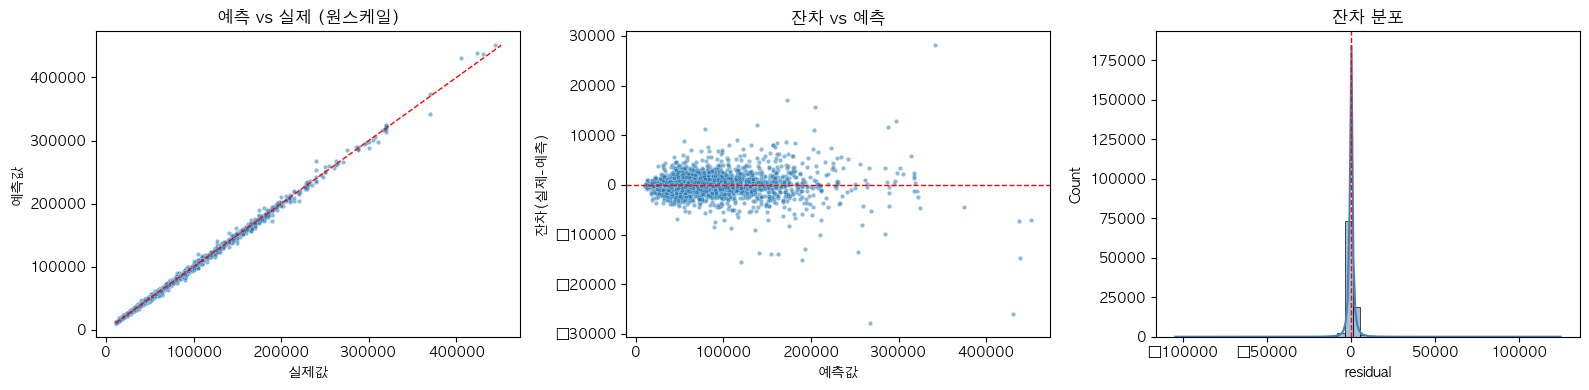

In [15]:
# 안전장치(음수 방지), 반올림 버전이 필요하면 아래 주석 해제
y_pred = np.maximum(0, y_pred)
# y_pred_int = y_pred.round().astype(np.int64)

# 지표 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = np.mean(np.abs(y_true - y_pred))
r2 = r2_score(y_true, y_pred)

print(f"[Train In-sample] RMSE(orig) = {rmse:,.4f}")
print(f"[Train In-sample] MAE(orig)  = {mae:,.4f}")
print(f"[Train In-sample] R²         = {r2:,.4f}")

# 비교/잔차 프레임
compare_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
})
compare_df['residual'] = compare_df['y_true'] - compare_df['y_pred']
display(compare_df.head(10))

# 필요 시 저장
# compare_df.to_csv('rf_train_vs_pred.csv', index=False)

# 시각화(샘플 5,000개까지)
sample = compare_df.sample(min(5000, len(compare_df)), random_state=2023)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1) 예측 vs 실제
sns.scatterplot(x='y_true', y='y_pred', data=sample, s=10, alpha=0.5, ax=axes[0])
lim_min = min(sample['y_true'].min(), sample['y_pred'].min())
lim_max = max(sample['y_true'].max(), sample['y_pred'].max())
axes[0].plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--', linewidth=1)
axes[0].set_title('예측 vs 실제 (원스케일)')
axes[0].set_xlabel('실제값')
axes[0].set_ylabel('예측값')

# 2) 잔차 vs 예측
sns.scatterplot(x='y_pred', y='residual', data=sample, s=10, alpha=0.5, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('잔차 vs 예측')
axes[1].set_xlabel('예측값')
axes[1].set_ylabel('잔차(실제-예측)')

# 3) 잔차 분포
sns.histplot(compare_df['residual'], bins=50, kde=True, ax=axes[2], color='steelblue')
axes[2].axvline(0, color='red', linestyle='--', linewidth=1)
axes[2].set_title('잔차 분포')

plt.tight_layout()
plt.show()

In [16]:
# 교차검증 요약
print(f"[KFold] CV RMSE(orig): mean={np.mean(fold_rmses):,.5f}, std={np.std(fold_rmses):,.5f}")
print(f"[KFold] Best fold = {best_fold}, RMSE(orig) = {best_fold_rmse:,.5f}, best_iter = {best_iteration}")

# 테스트 예측: 베스트 폴드 단일 모델만 사용
preds_best_log = best_model.predict(X_test, num_iteration=best_iteration)
preds_best = np.expm1(preds_best_log).astype(np.int64)

[KFold] CV RMSE(orig): mean=5,304.77891, std=301.07452
[KFold] Best fold = 2, RMSE(orig) = 4,865.30576, best_iter = 17249


In [17]:
# 저장
sub_path = 'lgbm_kfold_basic_bestfold.csv'
pd.DataFrame({'target': preds_best}).to_csv(sub_path, index=False)
print(f"[SAVE] {sub_path} 저장 완료")

[SAVE] lgbm_kfold_basic_bestfold.csv 저장 완료


In [18]:
preds_best

array([157549, 194045, 221435, ...,  51676,  46601,  47325], shape=(9272,))

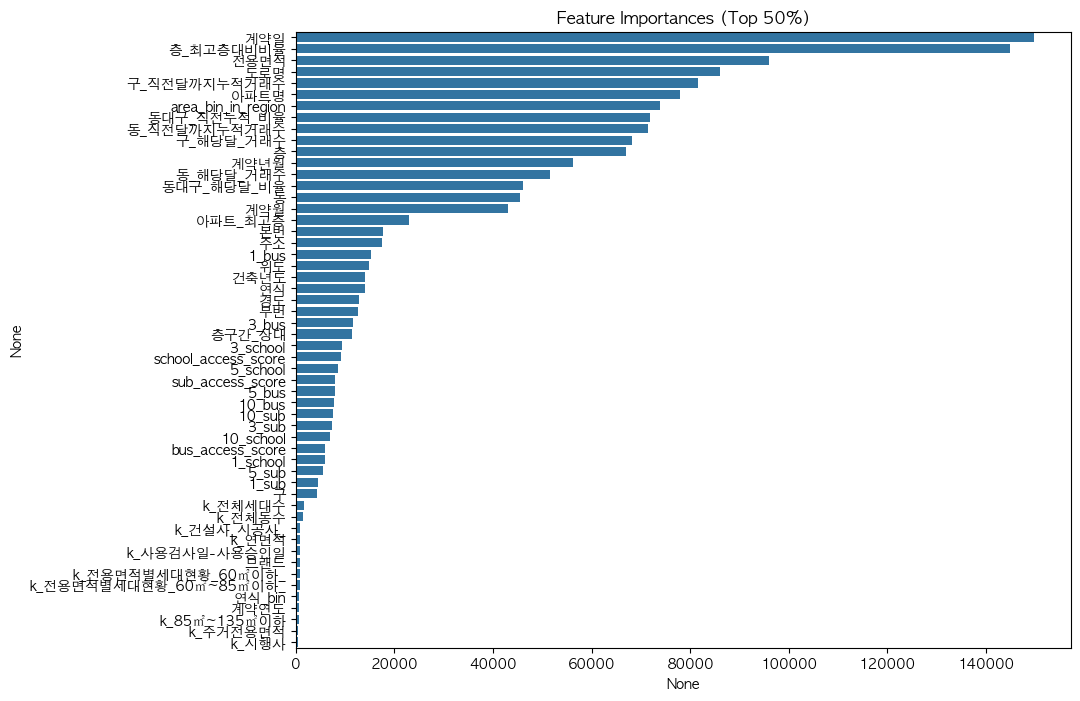

In [19]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X.columns))
importances = importances.sort_values(ascending=False)

# 상위 50%만 선택
top_n = max(1, int(np.ceil(len(importances) * 0.8)))
importances = importances.iloc[:top_n]

plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Top 50%)")
sns.barplot(x=importances, y=importances.index)
plt.show()